puntuacion: 0.646225


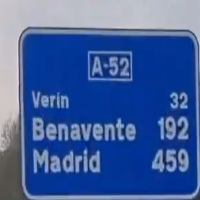

resultado IoU:  0.7659571031720396
puntuacion: 0.646225


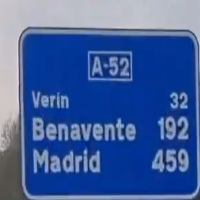

resultado IoU:  0.7659571031720396
puntuacion: 0.646225


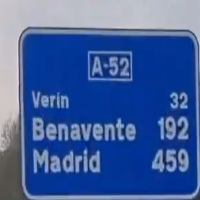

resultado IoU:  0.7659571031720396
puntuacion: 0.646225


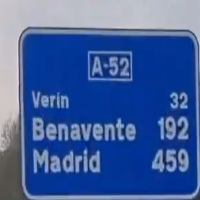

resultado IoU:  0.7659571031720396
puntuacion: 0.646225


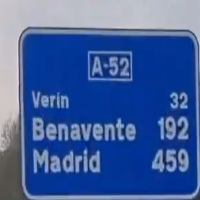

resultado IoU:  0.7659571031720396
puntuacion: 0.64255


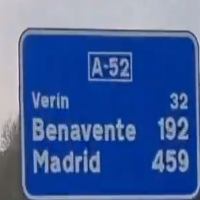

resultado IoU:  0.762251474677339
puntuacion: 0.64255


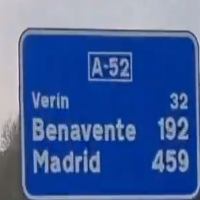

resultado IoU:  0.762251474677339
puntuacion: 0.64255


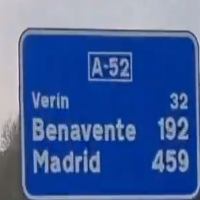

resultado IoU:  0.762251474677339
puntuacion: 0.64255


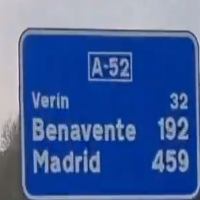

resultado IoU:  0.762251474677339
puntuacion: 0.64255


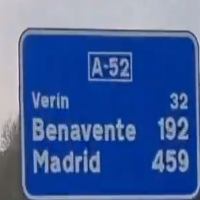

resultado IoU:  0.762251474677339
puntuacion: 0.640075


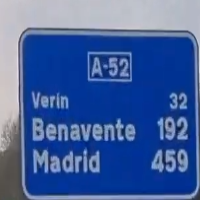

resultado IoU:  0.7597603370660515
puntuacion: 0.636875


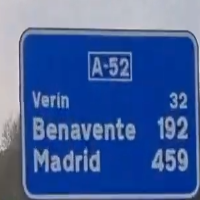

resultado IoU:  0.7612238057998308
puntuacion: 0.636875


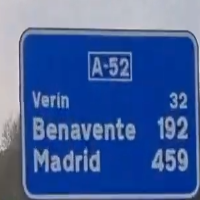

resultado IoU:  0.7612238057998308


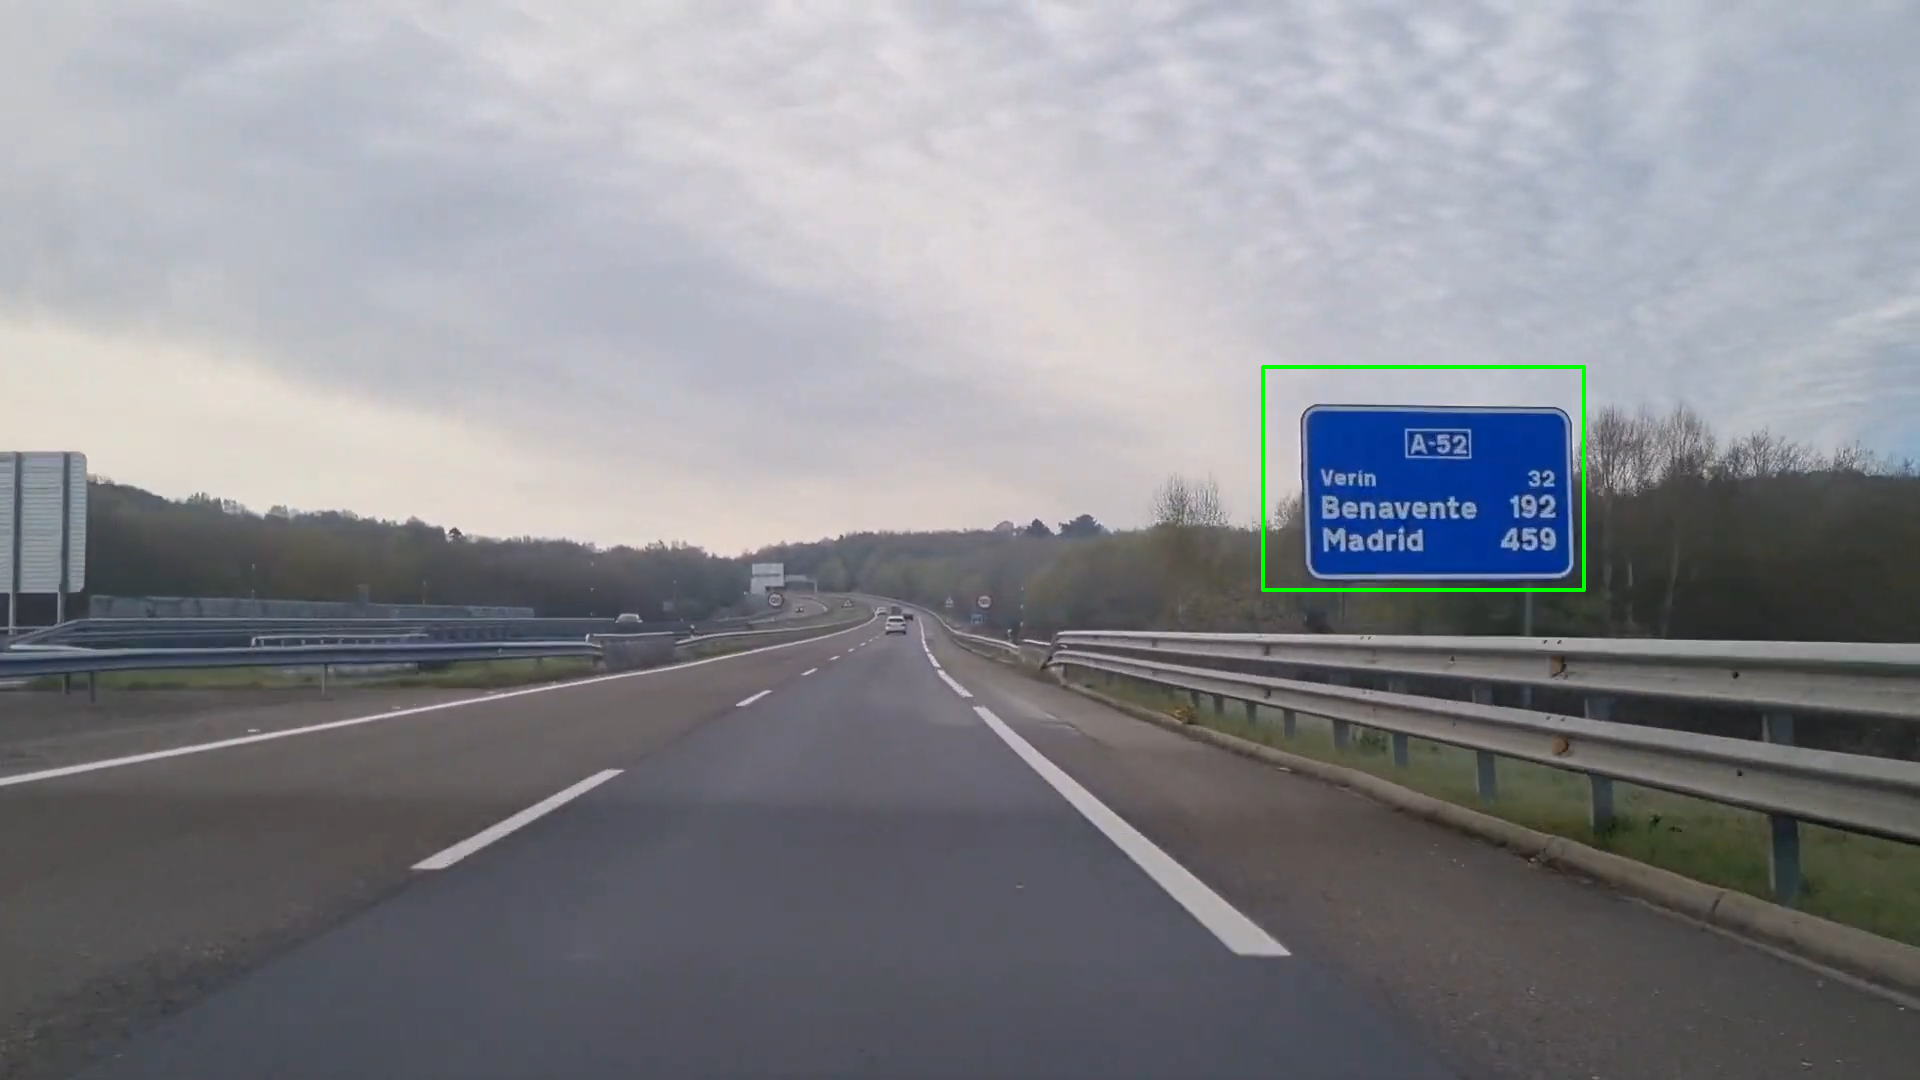

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow

import json

# cargar el archivo JSON
with open('anotaciones/Anotaciones.json', 'r') as f:
    data = json.load(f)

nombre_imagen= "00003.png"

imagenes = []

# Iterar sobre las imágenes
for imagen_id, imagen_data in data.items():
    #print(f'Imagen: {imagen_data["filename"]}')
    # Iterar sobre las regiones
    image_name = imagen_data["filename"]
    for region in imagen_data['regions']:
        if image_name == nombre_imagen:
            shape_attributes = region['shape_attributes']
            x1_img = shape_attributes["x"]
            y1_img = shape_attributes["y"]
            height = shape_attributes["height"]
            width = shape_attributes["width"]
            x2_img = x1_img + width
            y2_img = y1_img + height
            imagenes.append(x1_img)
            imagenes.append(y1_img)
            imagenes.append(x2_img)
            imagenes.append(y2_img)




# Cargar la imagen
img = cv2.imread('imgs/' + nombre_imagen)

# Convertir la imagen a gris para que el azul se detecte mejor
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mser = cv2.MSER_create(1, 2000, 8000)

# Detectar regiones
(regions,_) = mser.detectRegions(gray)

# Crear una lista vacía para almacenar los sub-paneles detectados
subpanels = []

puntuacion = []

dim_totales = []

# Iterar sobre las regiones detectadas
for region in regions:
    # Obtener las coordenadas del rectángulo que rodea a la región
    x, y, w, h = cv2.boundingRect(region)
    
    # Calcular la relación de aspecto del rectángulo
    aspect_ratio = w / h
    x-= 30
    y-=30
    w += 30
    h += 30
    # Si la relación de aspecto es razonable, añadir la región a la lista de sub-paneles
    if  aspect_ratio <= 2.5 and  0.5 <= aspect_ratio:
        # Asegurarse de que los límites del rectángulo no sobrepasen los límites de la imagen
        x, y, w, h = max(x, 0), max(y, 0), min(w, img.shape[1] - x), min(h, img.shape[0] - y)
        # Recortar la ventana detectada y redimensionarla
        window = img[y:y+h, x:x+w]
        dim_totales.append([x,y, x+w, y+h])
        window_resized = cv2.resize(window, (200, 200))

        subpanel_hsv = cv2.cvtColor(window_resized, cv2.COLOR_BGR2HSV)

        mascara_hsv = np.zeros((200,200))

        for i in range(200):
            for j in range(200):
                pixel = subpanel_hsv[i,j]
                if (pixel[0] >=0 and pixel[0] <= 150 and pixel[1] >= 100  and pixel[2] >= 100):
                    mascara_hsv[i,j] = 1
        # Definir la máscara ideal de color azul saturado
        mascara_ideal = np.ones((200, 200))

        # Correlar M (multiplicar los elementos de la mascara ideal (todo unos) con nuestra mascara azul)
        correlation = np.sum(mascara_hsv * mascara_ideal)/ np.sum(mascara_ideal)

        # Establecer un umbral y añadir el sub-panel a la lista de sub-paneles si la correlación es mayor que el umbral
        threshold = 0.0
        if correlation >= threshold:
            puntuacion.append(correlation)
            subpanels.append(window_resized)

def iou(boxA, boxB):
    # Obtener coordenadas del rectángulo de intersección
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Calcular el área de intersección
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Calcular el área de las dos cajas de delimitación
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Calcular el índice de intersección sobre unión
    iou = interArea / float(boxAArea + boxBArea - interArea) 

    # Devolver el índice de intersección sobre unión
    return iou

# Mostrar los sub-paneles detectados
for i in range (len(subpanels)):
    if(puntuacion[i] > .3):
        print("puntuacion:", puntuacion[i])
        cv2_imshow(subpanels[i])
        print("resultado IoU: " ,iou(imagenes, dim_totales[i]))
        cuadrado = dim_totales[i]
        cv2.rectangle(img,(cuadrado[0] - 10, cuadrado[1]- 10),(cuadrado[2] +10, cuadrado[3] +10), (0,255,0), 2)

cv2_imshow(img)

# Nueva sección